This tutorial is an implementation of the paper published in 2016 by Saw Simeon et al " https://peerj.com/articles/2322/ ".

A ML QSAR model will be built for AChE enzyme with the aim of finding new drugs that could inhibit AChE and alleviate AD. 

Dataset for known AChE inhibitors will be collected from ChEMBL database. This will be followed by exploratory data analysis to preprocess the data before generating molecular descriptors. In the paper, 12 different fingerprints were generated using PaDeL software. Here, only 3 types of FP will be implemented in addition to those who could describe Ro5 (Molwt, HbD, HbA, LogP). Feature selection will be performed for each FP using RFE and multicolinearity removal. RandomForest Classifier will be used for building the model.







In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### A- Data Acquisition 

Dataset comprising 15540 activities was downloaded from ChEMBL database. 

In [63]:
df = pd.read_csv("ache_activity.csv",sep=";")

In [64]:
df.head()

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties
0,CHEMBL562,GRISEOFULVIN,4,352.77,0,2.81,GRISEOFULVIN,COC1=CC(=O)C[C@@H](C)[C@]12Oc1c(Cl)c(OC)cc(OC)...,Ki,NaN,...,Acetylcholinesterase,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3307715,NaN
1,CHEMBL452,CLONAZEPAM,4,315.72,0,3.04,CLONAZEPAM,O=C1CN=C(c2ccccc2Cl)c2cc([N+](=O)[O-])ccc2N1,IC50,NaN,...,Acetylcholinesterase,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3307715,NaN
2,CHEMBL13209,NITRAZEPAM,4,281.27,0,2.38,NITRAZEPAM,O=C1CN=C(c2ccccc2)c2cc([N+](=O)[O-])ccc2N1,IC50,NaN,...,Acetylcholinesterase,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3307715,NaN
3,CHEMBL13209,NITRAZEPAM,4,281.27,0,2.38,NITRAZEPAM,O=C1CN=C(c2ccccc2)c2cc([N+](=O)[O-])ccc2N1,Ki,NaN,...,Acetylcholinesterase,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3307715,NaN
4,CHEMBL1055,CHLORTHALIDONE,4,338.77,0,0.92,CHLORTHALIDONE,NS(=O)(=O)c1cc(C2(O)NC(=O)c3ccccc32)ccc1Cl,Ki,NaN,...,Acetylcholinesterase,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3307715,NaN


In [65]:
df.columns

Index(['Molecule ChEMBL ID', 'Molecule Name', 'Molecule Max Phase',
       'Molecular Weight', '#RO5 Violations', 'AlogP', 'Compound Key',
       'Smiles', 'Standard Type', 'Standard Relation', 'Standard Value',
       'Standard Units', 'pChEMBL Value', 'Data Validity Comment', 'Comment',
       'Uo Units', 'Ligand Efficiency BEI', 'Ligand Efficiency LE',
       'Ligand Efficiency LLE', 'Ligand Efficiency SEI', 'Potential Duplicate',
       'Assay ChEMBL ID', 'Assay Description', 'Assay Type', 'BAO Format ID',
       'BAO Label', 'Assay Organism', 'Assay Tissue ChEMBL ID',
       'Assay Tissue Name', 'Assay Cell Type', 'Assay Subcellular Fraction',
       'Assay Parameters', 'Assay Variant Accession', 'Assay Variant Mutation',
       'Target ChEMBL ID', 'Target Name', 'Target Organism', 'Target Type',
       'Document ChEMBL ID', 'Source ID', 'Source Description',
       'Document Journal', 'Document Year', 'Cell ChEMBL ID', 'Properties'],
      dtype='object')

In [66]:
df = df[["Molecule ChEMBL ID",'Smiles','Standard Type', 'Standard Relation', 'Standard Value',
       'Standard Units' ]]

In [67]:
df.head()

,Molecule ChEMBL ID,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units
0,CHEMBL562,COC1=CC(=O)C[C@@H](C)[C@]12Oc1c(Cl)c(OC)cc(OC)...,Ki,NaN,NaN,NaN
1,CHEMBL452,O=C1CN=C(c2ccccc2Cl)c2cc([N+](=O)[O-])ccc2N1,IC50,NaN,NaN,NaN
2,CHEMBL13209,O=C1CN=C(c2ccccc2)c2cc([N+](=O)[O-])ccc2N1,IC50,NaN,NaN,NaN
3,CHEMBL13209,O=C1CN=C(c2ccccc2)c2cc([N+](=O)[O-])ccc2N1,Ki,NaN,NaN,NaN
4,CHEMBL1055,NS(=O)(=O)c1cc(C2(O)NC(=O)c3ccccc32)ccc1Cl,Ki,NaN,NaN,NaN


+ Checking Standard Type column. 

<AxesSubplot:xlabel='count', ylabel='Standard Type'>

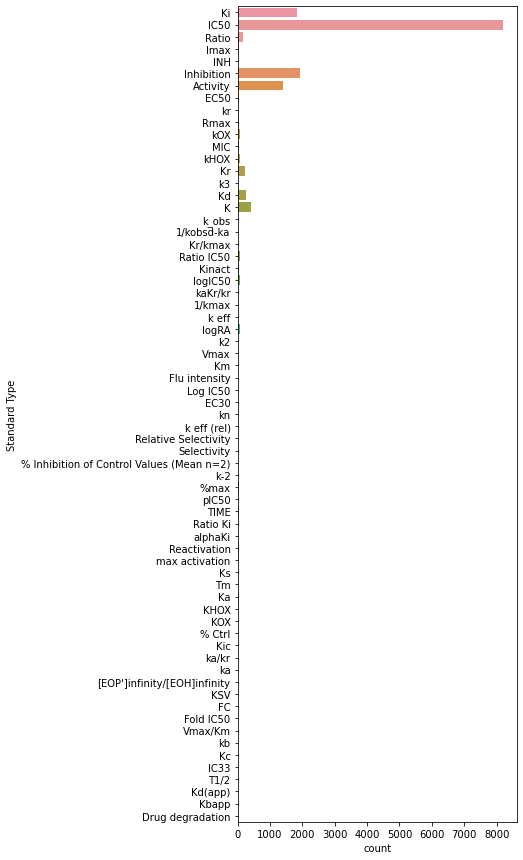

In [68]:
plt.figure(figsize=(5,15))
sns.countplot(y=df["Standard Type"])

+ IC50 is the most frequent activity data present so it will be used for further analysis.

In [69]:
df = df[df["Standard Type"] == "IC50"]

In [70]:
df.head()

,Molecule ChEMBL ID,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units
1,CHEMBL452,O=C1CN=C(c2ccccc2Cl)c2cc([N+](=O)[O-])ccc2N1,IC50,NaN,NaN,NaN
2,CHEMBL13209,O=C1CN=C(c2ccccc2)c2cc([N+](=O)[O-])ccc2N1,IC50,NaN,NaN,NaN
5,CHEMBL1140,NC(=O)c1cccnc1,IC50,NaN,NaN,NaN
12,CHEMBL1909054,NaN,IC50,NaN,NaN,NaN
13,CHEMBL1200528,NaN,IC50,NaN,NaN,NaN


In [71]:
df.shape

(8205, 6)

+ This results in 8205 compounds. 

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8205 entries, 1 to 15540
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Molecule ChEMBL ID  8205 non-null   object 
 1   Smiles              8170 non-null   object 
 2   Standard Type       8205 non-null   object 
 3   Standard Relation   6949 non-null   object 
 4   Standard Value      6949 non-null   float64
 5   Standard Units      6970 non-null   object 
dtypes: float64(1), object(5)
memory usage: 448.7+ KB


+ Remove molecules which has no SMILES

In [73]:
df = df[df["Smiles"].notnull()]

In [74]:
df.head()

,Molecule ChEMBL ID,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units
1,CHEMBL452,O=C1CN=C(c2ccccc2Cl)c2cc([N+](=O)[O-])ccc2N1,IC50,NaN,NaN,NaN
2,CHEMBL13209,O=C1CN=C(c2ccccc2)c2cc([N+](=O)[O-])ccc2N1,IC50,NaN,NaN,NaN
5,CHEMBL1140,NC(=O)c1cccnc1,IC50,NaN,NaN,NaN
16,CHEMBL95,Nc1c2c(nc3ccccc13)CCCC2,IC50,'=',480.0,nM
17,CHEMBL4752675,CO[C@]1(c2cn(O)c(=O)c(C(=O)[C@@H]3[C@H](C)C=C[...,IC50,'=',810.0,nM


In [75]:
df.shape

(8170, 6)

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8170 entries, 1 to 15540
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Molecule ChEMBL ID  8170 non-null   object 
 1   Smiles              8170 non-null   object 
 2   Standard Type       8170 non-null   object 
 3   Standard Relation   6947 non-null   object 
 4   Standard Value      6947 non-null   float64
 5   Standard Units      6968 non-null   object 
dtypes: float64(1), object(5)
memory usage: 446.8+ KB


+ Remove all Null values.

In [77]:
df = df.dropna()

In [78]:
df

,Molecule ChEMBL ID,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units
16,CHEMBL95,Nc1c2c(nc3ccccc13)CCCC2,IC50,'=',480.00,nM
17,CHEMBL4752675,CO[C@]1(c2cn(O)c(=O)c(C(=O)[C@@H]3[C@H](C)C=C[...,IC50,'=',810.00,nM
18,CHEMBL571730,O=S(=O)(/N=C(\NCCCCNc1c2c(nc3ccccc13)CCCC2)N1C...,IC50,'=',2511.89,nM
25,CHEMBL3415559,O=C1c2ccccc2C(=O)N1CCCCCCNCc1ccccc1,IC50,'=',2105.00,nM
26,CHEMBL3415564,O=C1c2ccccc2C(=O)N1CCCCCCNCc1ccccc1F,IC50,'=',941.00,nM
...,...,...,...,...,...,...
15530,CHEMBL94186,COc1ccc2onc(CCC3CCN(Cc4ccccc4)CC3)c2c1,IC50,'=',7.20,nM
15532,CHEMBL1677,Cl.Nc1c2c(nc3ccccc13)CCCC2,IC50,'=',205.00,nM
15533,CHEMBL95,Nc1c2c(nc3ccccc13)CCCC2,IC50,'=',420.00,nM
15537,CHEMBL95,Nc1c2c(nc3ccccc13)CCCC2,IC50,'=',180.00,nM


In [79]:
df.shape

(6947, 6)

In [80]:
df.head()

,Molecule ChEMBL ID,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units
16,CHEMBL95,Nc1c2c(nc3ccccc13)CCCC2,IC50,'=',480.00,nM
17,CHEMBL4752675,CO[C@]1(c2cn(O)c(=O)c(C(=O)[C@@H]3[C@H](C)C=C[...,IC50,'=',810.00,nM
18,CHEMBL571730,O=S(=O)(/N=C(\NCCCCNc1c2c(nc3ccccc13)CCCC2)N1C...,IC50,'=',2511.89,nM
25,CHEMBL3415559,O=C1c2ccccc2C(=O)N1CCCCCCNCc1ccccc1,IC50,'=',2105.00,nM
26,CHEMBL3415564,O=C1c2ccccc2C(=O)N1CCCCCCNCc1ccccc1F,IC50,'=',941.00,nM


+ Checking for Standard Units

In [81]:
df["Standard Units"].value_counts()

nM             6908
ug.mL-1          31
10'5pM            3
10^-4microM       2
10'6pM            2
10'3pM            1
Name: Standard Units, dtype: int64

+ We keep only nM values. 

In [82]:
df = df[df["Standard Units"] == "nM"]

In [83]:
df.shape

(6908, 6)

+ Checking for Standard Relation

In [84]:
df["Standard Relation"].value_counts()

'='     6244
'>'      649
'<'       11
'>>'       2
'~'        2
Name: Standard Relation, dtype: int64

+ We will keep only "=" values since other values are not decisive. 

In [85]:
df = df[df["Standard Relation"] == "'='"]

In [86]:
df.head()

,Molecule ChEMBL ID,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units
16,CHEMBL95,Nc1c2c(nc3ccccc13)CCCC2,IC50,'=',480.00,nM
17,CHEMBL4752675,CO[C@]1(c2cn(O)c(=O)c(C(=O)[C@@H]3[C@H](C)C=C[...,IC50,'=',810.00,nM
18,CHEMBL571730,O=S(=O)(/N=C(\NCCCCNc1c2c(nc3ccccc13)CCCC2)N1C...,IC50,'=',2511.89,nM
25,CHEMBL3415559,O=C1c2ccccc2C(=O)N1CCCCCCNCc1ccccc1,IC50,'=',2105.00,nM
26,CHEMBL3415564,O=C1c2ccccc2C(=O)N1CCCCCCNCc1ccccc1F,IC50,'=',941.00,nM


In [87]:
df.shape

(6244, 6)

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6244 entries, 16 to 15540
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Molecule ChEMBL ID  6244 non-null   object 
 1   Smiles              6244 non-null   object 
 2   Standard Type       6244 non-null   object 
 3   Standard Relation   6244 non-null   object 
 4   Standard Value      6244 non-null   float64
 5   Standard Units      6244 non-null   object 
dtypes: float64(1), object(5)
memory usage: 341.5+ KB


+ Check for duplicate molecules.

In [91]:
df["Molecule ChEMBL ID"].value_counts().reset_index().head(20)

,index,Molecule ChEMBL ID
0,CHEMBL95,156
1,CHEMBL502,120
2,CHEMBL659,67
3,CHEMBL94,47
4,CHEMBL636,41
5,CHEMBL1255901,18
6,CHEMBL292314,16
7,CHEMBL345124,13
8,CHEMBL433041,13
9,CHEMBL140476,12


+ There are so many molecules which are duplicated. 

In [102]:
df.groupby("Molecule ChEMBL ID")["Standard Value"].describe().sort_values(by="count",ascending = False).head(20)

,count,mean,std,min,25%,50%,75%,max
Molecule ChEMBL ID,,,,,,,,
CHEMBL95,156.0,2.930052e+13,3.659634e+14,3.160,130.7500,240.000,414.00000,4.570882e+15
CHEMBL502,120.0,2.335387e+02,1.087093e+03,2.000,9.0000,16.000,31.85000,7.560000e+03
CHEMBL659,67.0,4.467109e+03,1.404909e+04,100.000,600.0000,1270.000,2350.00000,9.000000e+04
CHEMBL94,47.0,1.506268e+15,1.032645e+16,0.430,27.9000,43.000,128.00000,7.079458e+16
CHEMBL636,41.0,4.554317e+03,7.575742e+03,37.000,1535.0000,3030.000,4150.00000,4.800000e+04
CHEMBL1255901,18.0,1.821411e+02,3.919425e+02,0.540,14.2500,47.000,232.50000,1.700000e+03
CHEMBL292314,16.0,1.181250e+01,5.937577e+00,1.800,8.5450,11.600,15.27500,2.000000e+01
CHEMBL345124,13.0,2.681077e+04,1.134142e+04,7140.000,13000.0000,32300.000,32300.00000,4.500000e+04
CHEMBL433041,13.0,1.751077e+03,6.084577e+03,5.000,22.0000,22.000,110.00000,2.200000e+04


+ To solve this issue, we will sort the dataset in descending order then remove duplicates and keep only one value.

In [107]:
df = df.sort_values(by="Standard Value",ascending = False)

In [110]:
df.drop_duplicates("Molecule ChEMBL ID",keep="first",inplace=True)

In [112]:
df.reset_index(drop=True,inplace=True)

In [113]:
df.head()

,Molecule ChEMBL ID,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units
0,CHEMBL94,CNC(=O)Oc1ccc2c(c1)[C@]1(C)CCN(C)[C@@H]1N2C,IC50,'=',7.079458e+16,nM
1,CHEMBL11805,COc1ccccc1CN(C)CCCCCC(=O)N(C)CCCCCCCCN(C)C(=O)...,IC50,'=',5.888437e+15,nM
2,CHEMBL95,Nc1c2c(nc3ccccc13)CCCC2,IC50,'=',4.570882e+15,nM
3,CHEMBL132377,COc1ccccc1CNCCCCCC(=O)N(C)CCCCCCCCN(C)C(=O)CCC...,IC50,'=',3.235937e+15,nM
4,CHEMBL134488,COc1ccccc1CNCCCCCC(=O)NCCCCCCCCNC(=O)CCCCCNCc1...,IC50,'=',5.370318e+14,nM


In [114]:
df.shape

(5005, 6)

+ This results in total of 5005 compounds. 

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5005 entries, 0 to 5004
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Molecule ChEMBL ID  5005 non-null   object 
 1   Smiles              5005 non-null   object 
 2   Standard Type       5005 non-null   object 
 3   Standard Relation   5005 non-null   object 
 4   Standard Value      5005 non-null   float64
 5   Standard Units      5005 non-null   object 
dtypes: float64(1), object(5)
memory usage: 234.7+ KB


+ For classification problem we need to specificy actives and inactives. For this, we will use a 10 uM threshold. Molecules with lower values are labeled as actives (1) and above will be labeled inactive (0) 

In [120]:
label = []

for i in df["Standard Value"]: 
    if i <= 10000:
        label.append(1)
    else:
        label.append(0)

In [125]:
df["label"] = label

In [126]:
df.head()

,Molecule ChEMBL ID,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units,label
0,CHEMBL94,CNC(=O)Oc1ccc2c(c1)[C@]1(C)CCN(C)[C@@H]1N2C,IC50,'=',7.079458e+16,nM,0
1,CHEMBL11805,COc1ccccc1CN(C)CCCCCC(=O)N(C)CCCCCCCCN(C)C(=O)...,IC50,'=',5.888437e+15,nM,0
2,CHEMBL95,Nc1c2c(nc3ccccc13)CCCC2,IC50,'=',4.570882e+15,nM,0
3,CHEMBL132377,COc1ccccc1CNCCCCCC(=O)N(C)CCCCCCCCN(C)C(=O)CCC...,IC50,'=',3.235937e+15,nM,0
4,CHEMBL134488,COc1ccccc1CNCCCCCC(=O)NCCCCCCCCNC(=O)CCCCCNCc1...,IC50,'=',5.370318e+14,nM,0


<AxesSubplot:xlabel='label', ylabel='count'>

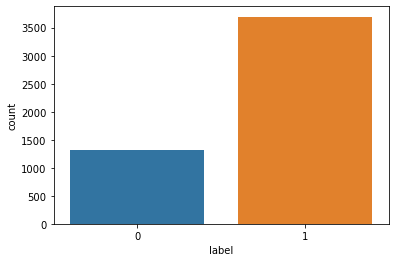

In [129]:
sns.countplot(x=df["label"],)

In [130]:
df["label"].value_counts()

1    3695
0    1310
Name: label, dtype: int64

+ This might represent a case of ***imbalanced dataset***. We will come to this later. 

/Users/sherifelsabbagh/opt/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Standard Value', ylabel='Density'>

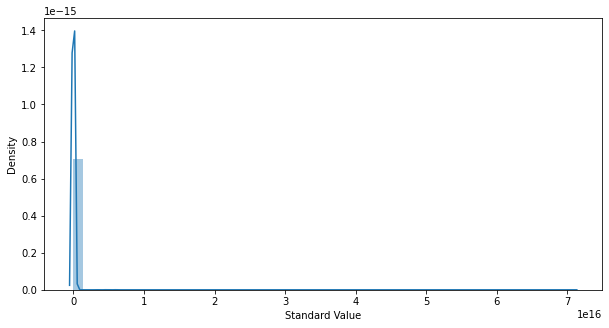

In [145]:
plt.figure(figsize=(10,5))
sns.distplot(df["Standard Value"])

+ Molecules show a highly variable IC50. To be able to compare easily, we will calculate pIC50 values instead.

In [146]:
import math

In [147]:
df["pIC50"] = [9 - math.log10(x) for x in df["Standard Value"]]

ValueError: math domain error

+ This issue is raised because there may be zero values which cannot be converted. 

In [148]:
df[df["Standard Value"] == 0]

,Molecule ChEMBL ID,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units,label
5004,CHEMBL4780352,COc1cc2c(cc1OC)C(=O)/C(=C/c1ccc(OCCCCN[N+]3(C)...,IC50,'=',0.0,nM,1


In [149]:
df_ = df[df["Standard Value"] != 0]

In [150]:
df_

,Molecule ChEMBL ID,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units,label
0,CHEMBL94,CNC(=O)Oc1ccc2c(c1)[C@]1(C)CCN(C)[C@@H]1N2C,IC50,'=',7.079458e+16,nM,0
1,CHEMBL11805,COc1ccccc1CN(C)CCCCCC(=O)N(C)CCCCCCCCN(C)C(=O)...,IC50,'=',5.888437e+15,nM,0
2,CHEMBL95,Nc1c2c(nc3ccccc13)CCCC2,IC50,'=',4.570882e+15,nM,0
3,CHEMBL132377,COc1ccccc1CNCCCCCC(=O)N(C)CCCCCCCCN(C)C(=O)CCC...,IC50,'=',3.235937e+15,nM,0
4,CHEMBL134488,COc1ccccc1CNCCCCCC(=O)NCCCCCCCCNC(=O)CCCCCNCc1...,IC50,'=',5.370318e+14,nM,0
...,...,...,...,...,...,...,...
4999,CHEMBL383663,O=C(CCCCCNc1c2c(nc3cc(Cl)ccc13)CCCC2)NCCc1c[nH...,IC50,'=',5.000000e-06,nM,1
5000,CHEMBL199861,O=C(CCCCCNc1c2c(nc3ccccc13)CCCC2)NCCc1c[nH]c2c...,IC50,'=',5.000000e-06,nM,1
5001,CHEMBL4443426,O=C(CCCCNc1c2c(nc3ccccc13)CCCC2)NCCc1c[nH]c2cc...,IC50,'=',5.000000e-06,nM,1
5002,CHEMBL4590945,O=C(CCCCCCCNc1c2c(nc3cc(Cl)cc(Cl)c13)CCCC2)NCC...,IC50,'=',5.000000e-06,nM,1


In [151]:
df = df_

In [152]:
df["pIC50"] = [9 - math.log10(x) for x in df["Standard Value"]]

/var/folders/ng/whnp3t611lq2k8dzf4hzhtnw0000gn/T/ipykernel_4990/1761143420.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pIC50"] = [9 - math.log10(x) for x in df["Standard Value"]]


In [153]:
df.head()

,Molecule ChEMBL ID,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units,label,pIC50
0,CHEMBL94,CNC(=O)Oc1ccc2c(c1)[C@]1(C)CCN(C)[C@@H]1N2C,IC50,'=',7.079458e+16,nM,0,-7.85
1,CHEMBL11805,COc1ccccc1CN(C)CCCCCC(=O)N(C)CCCCCCCCN(C)C(=O)...,IC50,'=',5.888437e+15,nM,0,-6.77
2,CHEMBL95,Nc1c2c(nc3ccccc13)CCCC2,IC50,'=',4.570882e+15,nM,0,-6.66
3,CHEMBL132377,COc1ccccc1CNCCCCCC(=O)N(C)CCCCCCCCN(C)C(=O)CCC...,IC50,'=',3.235937e+15,nM,0,-6.51
4,CHEMBL134488,COc1ccccc1CNCCCCCC(=O)NCCCCCCCCNC(=O)CCCCCNCc1...,IC50,'=',5.370318e+14,nM,0,-5.73


/Users/sherifelsabbagh/opt/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='pIC50', ylabel='Density'>

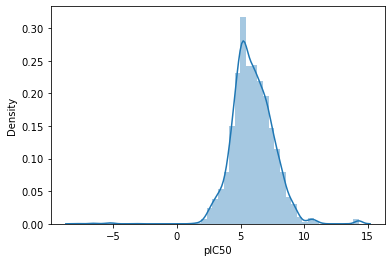

In [158]:
sns.distplot(df["pIC50"])

In [159]:
df.to_csv("dataset.csv",sep="\t",index=None)